**Работу выполнил:** магистр группы М4145 Глеб Брыкин

**Основные улучшения:** добавлены аугментации данных, использованы другие функции потери, использована другая архитектура нейросети, существенно оптимизированы коды работы с изображениями

**Аугментации данных:** отражения по горизонтали и вертикали, повороты

**Функции потери:** Huber Loss и Focal Frequency Loss вместо MSE

**Архитектура нейросети:** UNet-подобная архитектура

**Загрузим датасеты из исходного репозитория**

In [1]:
!git clone https://ctlab.itmo.ru/gitlab/eabelyaev/cnnimagequalityenhancement.git

Cloning into 'cnnimagequalityenhancement'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (41/41), 107.63 MiB | 3.09 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (15/15), done.


In [2]:
!mv cnnimagequalityenhancement/testcompyuv ./
!mv cnnimagequalityenhancement/testrawyuv ./
!mv cnnimagequalityenhancement/traincompyuv ./
!mv cnnimagequalityenhancement/trainrawyuv ./

In [3]:
!rm -rf cnnimagequalityenhancement

**Подготовим данные**

In [4]:
import os
import cv2
import numpy as np

# test folders for raw and compressed in yuv and png formats
testfolderRawYuv = './testrawyuv/'
testfolderRawPng = './testrawpng/'
testfolderCompYuv = './testcompyuv/'
testfolderCompPng = './testcomppng/'

# train folders for raw and compressed in yuv and png formats
trainfolderRawYuv = './trainrawyuv/'
trainfolderRawPng = './trainrawpng/'
trainfolderCompYuv = './traincompyuv/'
trainfolderCompPng = './traincomppng/'

def yuv2rgb(Y, U, V, fw, fh):
    U_new = cv2.resize(U, (fw, fh), cv2.INTER_CUBIC)
    V_new = cv2.resize(V, (fw, fh), cv2.INTER_CUBIC)
    rf = np.clip(Y + 1.4075 * (V_new - 128.0), 0, 255).astype(np.uint8)
    gf = np.clip(Y - 0.3455 * (U_new - 128.0) - 0.7169 * (V_new - 128.0), 0, 255).astype(np.uint8)
    bf = np.clip(Y + 1.7790 * (U_new - 128.0), 0, 255).astype(np.uint8)
    return rf, gf, bf

def FromFolderYuvToFolderPNG(folderyuv, folderpng, fw, fh):
    for filename in os.listdir(folderpng):
        os.remove(os.path.join(folderpng, filename))
    fwuv, fhuv = fw // 2, fh // 2
    Y = np.zeros((fh, fw), np.uint8)
    U = np.zeros((fhuv, fwuv), np.uint8)
    V = np.zeros((fhuv, fwuv), np.uint8)
    Im = np.zeros((fh, fw, 3), np.uint8)
    pngframenum = 0
    for name in os.listdir(folderyuv):
        fullname = os.path.join(folderyuv, name)
        if fullname.endswith('.yuv'):
            with open(fullname, 'rb') as fp:
                fp.seek(0, 2)
                size = fp.tell()
                frames = (2 * size) // (fw * fh * 3)
                fp.seek(0)
                for f in range(frames):
                    Y = np.frombuffer(fp.read(fw * fh), dtype=np.uint8).reshape((fh, fw))
                    U = np.frombuffer(fp.read(fwuv * fhuv), dtype=np.uint8).reshape((fhuv, fwuv))
                    V = np.frombuffer(fp.read(fwuv * fhuv), dtype=np.uint8).reshape((fhuv, fwuv))
                    r, g, b = yuv2rgb(Y, U, V, fw, fh)
                    Im[:, :, 0] = b
                    Im[:, :, 1] = g
                    Im[:, :, 2] = r
                    pngfilename = os.path.join(folderpng, f"{pngframenum}.png")
                    cv2.imwrite(pngfilename, Im)
                    pngframenum += 1
    return pngframenum

for d in [trainfolderRawPng, trainfolderCompPng, testfolderRawPng, testfolderCompPng]:
    os.makedirs(d, exist_ok=True)

w = 480
h = 320
FromFolderYuvToFolderPNG(trainfolderRawYuv, trainfolderRawPng, w, h)
FromFolderYuvToFolderPNG(trainfolderCompYuv, trainfolderCompPng, w, h)
FromFolderYuvToFolderPNG(testfolderRawYuv, testfolderRawPng, w, h)
FromFolderYuvToFolderPNG(testfolderCompYuv, testfolderCompPng, w, h)

100

**Загрузим данные**

In [5]:
import cv2
import PIL
import numpy as np
import torch.nn as nn
import torch.optim
import random
import os
from PIL import Image
from numpy import *

def LoadImagesFromFolder(foldername, dir_list):
    N = 0
    Nmax = 0
    for name in dir_list:
        fullname = foldername + name
        Nmax = Nmax + 1
    x = np.zeros([Nmax, 320, 480, 3])
    N = 0
    for name in dir_list:
        fullname = foldername + name
        I1 = cv2.imread(fullname)
        x[N, :, :, 0] = I1[:, :, 2]
        x[N, :, :, 1] = I1[:, :, 1]
        x[N, :, :, 2] = I1[:, :, 0]
        N = N + 1
    return x

print('Loading raw train images...')
train_dir_list = os.listdir(trainfolderRawPng)
random.shuffle(train_dir_list)
Xraw = LoadImagesFromFolder(trainfolderRawPng, train_dir_list)
print('Loading compressed train images...')
Xcomp = LoadImagesFromFolder(trainfolderCompPng, train_dir_list)
Xraw = Xraw / 255.0
Xcomp = Xcomp / 255.0

print('Loading raw validiation images...')
val_dir_list = os.listdir(testfolderRawPng)
XrawVal = LoadImagesFromFolder(testfolderRawPng, val_dir_list)
print('Loading compressed validiation images...')
XcompVal = LoadImagesFromFolder(testfolderCompPng, val_dir_list)
XrawVal = XrawVal / 255.0
XcompVal = XcompVal / 255.0

Loading raw train images...
Loading compressed train images...
Loading raw validiation images...
Loading compressed validiation images...


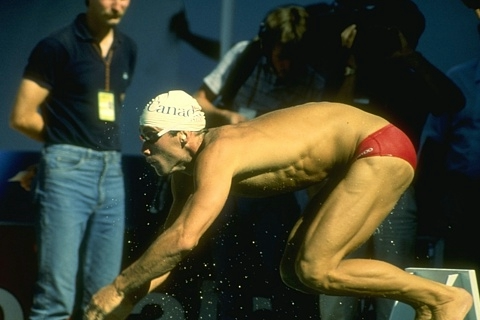

In [6]:
Image.fromarray((Xraw[0] * 255).astype(np.uint8))

**Аугментация данных**

In [7]:
import torchvision.transforms.functional as TF
import torchvision.transforms.v2.functional as TFV2
from torchvision.transforms import v2

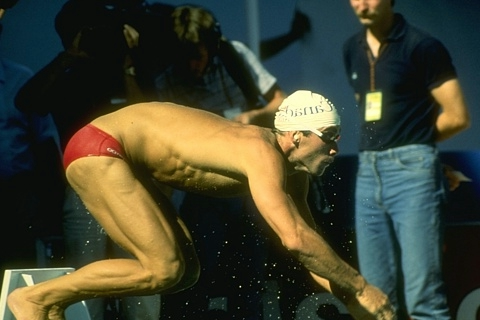

In [8]:
TF.hflip(Image.fromarray((Xraw[0] * 255).astype(np.uint8)))

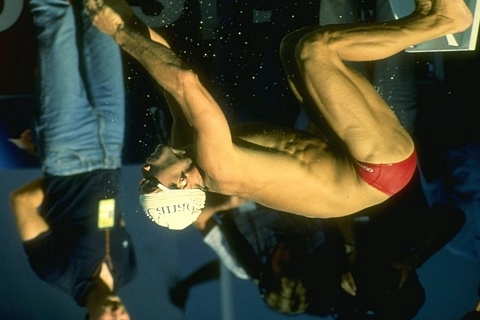

In [9]:
TF.vflip(Image.fromarray((Xraw[0] * 255).astype(np.uint8)))

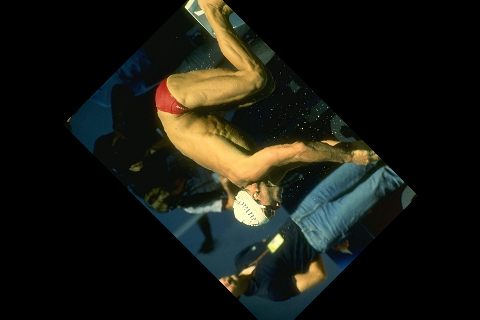

In [10]:
angle = random.randint(0, 360)
translate = (random.randint(100, 300) / 1000, random.randint(100, 300) / 1000)
scale = random.randint(500, 700)  / 1000

TFV2.affine(Image.fromarray((Xraw[0] * 255).astype(np.uint8)), angle=angle, translate=translate, scale=scale, shear=(0.0, 0.0))

**Класс датасета**

In [11]:
import torchvision.transforms.functional as TF
import torchvision.transforms.v2.functional as TFV2
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

    def __init__(self, Xraw, Xcomp):
        self.xraw = Xraw
        self.xcomp = Xcomp

    def transform(self, xraw, xcomp):
        xraw = Image.fromarray((xraw * 255).astype(np.uint8))
        xcomp = Image.fromarray((xcomp * 255).astype(np.uint8))

        # Random crop
        y, x = random.randint(0, 232), random.randint(0, 252)
        xraw = xraw.crop((x, y, x + 128, y + 128))
        xcomp = xcomp.crop((x, y, x + 128, y + 128))

        # Random horizontal flipping
        if random.random() > 0.5:
            xraw = TF.hflip(xraw)
            xcomp = TF.hflip(xcomp)

        # Random vertical flipping
        if random.random() > 0.5:
            xraw = TF.vflip(xraw)
            xcomp = TF.vflip(xcomp)

        # Randomm affine transform
        if random.random() > 0.5:
            angle = random.randint(0, 360)
            translate = (random.randint(100, 300) / 1000, random.randint(100, 300) / 1000)
            scale = random.randint(500, 700)  / 1000

            xraw = TFV2.affine(xraw, angle = angle, translate=translate, scale = scale, shear = (0.0, 0.0))
            xcomp = TFV2.affine(xcomp, angle = angle, translate=translate, scale = scale, shear = (0.0, 0.0))

        # Transform to tensor
        xraw = TF.to_tensor(xraw)
        xcomp = TF.to_tensor(xcomp)
        return xraw, xcomp

    def __getitem__(self, index):
        x, y = self.transform(self.xraw[index], self.xcomp[index])
        return x, y

    def __len__(self):
        return len(self.xraw)

train_dataset = MyDataset(Xraw, Xcomp)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

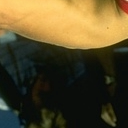

In [12]:
raw, comp = train_dataset[0]
raw = raw.numpy().transpose(1, 2, 0)
comp = comp.numpy().transpose(1, 2, 0)

Image.fromarray((raw * 255).astype(np.uint8))

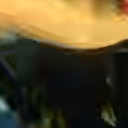

In [13]:
Image.fromarray((comp * 255).astype(np.uint8))

**Архитектура нейросети**

In [14]:
import torch
import torch.nn as nn

class EnhanceNet(nn.Module):

    def __init__(self) -> None:
        super().__init__();
        self.enc0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.PReLU(32),
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
            nn.PReLU(32)
        );
        self.enc1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.PReLU(64),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.PReLU(64)
        );
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.PReLU(128),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.PReLU(128)
        );
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.PReLU(256),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.PReLU(256)
        );
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
            nn.PixelShuffle(2),
            nn.PReLU(128),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.PReLU(128)
        );
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.PixelShuffle(2),
            nn.PReLU(64),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.PReLU(64),
        );
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.PixelShuffle(2),
            nn.PReLU(32),
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
            nn.PReLU(32)
        );
        self.dec0 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size = 3, padding = 1),
            nn.PReLU(32),
            nn.Conv2d(32, 3, kernel_size = 3, padding = 1)
        );
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = (x - self.mean) / self.std;
        residual = x;
        x0 = self.enc0(x);
        x1 = self.enc1(x0);
        x2 = self.enc2(x1);
        x3 = self.enc3(x2);
        y = self.dec3(x3);
        y = self.dec2(torch.cat([x2, y], dim = 1));
        y = self.dec1(torch.cat([x1, y], dim = 1));
        y = self.dec0(torch.cat([x0, y], dim = 1));
        y = y + residual;
        y = y * self.std + self.mean;
        return y;

**Focal Frequency Loss**

In [15]:
import torch.fft

class FocalFrequencyLoss(nn.Module):
    """The torch.nn.Module class that implements focal frequency loss - a
    frequency domain loss function for optimizing generative models.

    Ref:
    Focal Frequency Loss for Image Reconstruction and Synthesis. In ICCV 2021.
    <https://arxiv.org/pdf/2012.12821.pdf>

    Args:
        loss_weight (float): weight for focal frequency loss. Default: 1.0
        alpha (float): the scaling factor alpha of the spectrum weight matrix for flexibility. Default: 1.0
        patch_factor (int): the factor to crop image patches for patch-based focal frequency loss. Default: 1
        ave_spectrum (bool): whether to use minibatch average spectrum. Default: False
        log_matrix (bool): whether to adjust the spectrum weight matrix by logarithm. Default: False
        batch_matrix (bool): whether to calculate the spectrum weight matrix using batch-based statistics. Default: False
    """

    def __init__(self, loss_weight=1.0, alpha=1.0, patch_factor=1, ave_spectrum=False, log_matrix=False, batch_matrix=False):
        super(FocalFrequencyLoss, self).__init__()
        self.loss_weight = loss_weight
        self.alpha = alpha
        self.patch_factor = patch_factor
        self.ave_spectrum = ave_spectrum
        self.log_matrix = log_matrix
        self.batch_matrix = batch_matrix

    def tensor2freq(self, x):
        # crop image patches
        patch_factor = self.patch_factor
        _, _, h, w = x.shape
        assert h % patch_factor == 0 and w % patch_factor == 0, (
            'Patch factor should be divisible by image height and width')
        patch_list = []
        patch_h = h // patch_factor
        patch_w = w // patch_factor
        for i in range(patch_factor):
            for j in range(patch_factor):
                patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
        y = torch.stack(patch_list, 1)

        # perform 2D DFT (real-to-complex, orthonormalization)
        freq = torch.fft.fft2(y, norm='ortho')
        freq = torch.stack([freq.real, freq.imag], -1)
        return freq

    def loss_formulation(self, recon_freq, real_freq, matrix=None):
        # spectrum weight matrix
        if matrix is not None:
            # if the matrix is predefined
            weight_matrix = matrix.detach()
        else:
            # if the matrix is calculated online: continuous, dynamic, based on current Euclidean distance
            matrix_tmp = (recon_freq - real_freq) ** 2
            matrix_tmp = torch.sqrt(matrix_tmp[..., 0] + matrix_tmp[..., 1]) ** self.alpha

            # whether to adjust the spectrum weight matrix by logarithm
            if self.log_matrix:
                matrix_tmp = torch.log(matrix_tmp + 1.0)

            # whether to calculate the spectrum weight matrix using batch-based statistics
            if self.batch_matrix:
                matrix_tmp = matrix_tmp / matrix_tmp.max()
            else:
                matrix_tmp = matrix_tmp / matrix_tmp.max(-1).values.max(-1).values[:, :, :, None, None]

            matrix_tmp[torch.isnan(matrix_tmp)] = 0.0
            matrix_tmp = torch.clamp(matrix_tmp, min=0.0, max=1.0)
            weight_matrix = matrix_tmp.clone().detach()

        assert weight_matrix.min().item() >= 0 and weight_matrix.max().item() <= 1, (
            'The values of spectrum weight matrix should be in the range [0, 1], '
            'but got Min: %.10f Max: %.10f' % (weight_matrix.min().item(), weight_matrix.max().item()))

        # frequency distance using (squared) Euclidean distance
        tmp = (recon_freq - real_freq) ** 2
        freq_distance = tmp[..., 0] + tmp[..., 1]

        # dynamic spectrum weighting (Hadamard product)
        loss = weight_matrix * freq_distance
        return torch.mean(loss)

    def forward(self, pred, target, matrix=None, **kwargs):
        """Forward function to calculate focal frequency loss.

        Args:
            pred (torch.Tensor): of shape (N, C, H, W). Predicted tensor.
            target (torch.Tensor): of shape (N, C, H, W). Target tensor.
            matrix (torch.Tensor, optional): Element-wise spectrum weight matrix.
                Default: None (If set to None: calculated online, dynamic).
        """
        pred_freq = self.tensor2freq(pred)
        target_freq = self.tensor2freq(target)

        # whether to use minibatch average spectrum
        if self.ave_spectrum:
            pred_freq = torch.mean(pred_freq, 0, keepdim=True)
            target_freq = torch.mean(target_freq, 0, keepdim=True)

        # calculate focal frequency loss
        return self.loss_formulation(pred_freq, target_freq, matrix) * self.loss_weight

**Обучение**

In [16]:
batch_size = 16

device = torch.device("cuda")

model = EnhanceNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
huber_loss = torch.nn.HuberLoss()
ffl_loss = FocalFrequencyLoss(1)
model.to(device)
model.train()

avg_huber_loss = 0.0
avg_ffl_loss = 0.0
nb = 0

for ep in range(200):
    for xraw, xcomp in train_dataloader:
        lq = xcomp.to(device, torch.float)
        hq = xraw.to(device, torch.float)
        optimizer.zero_grad()
        predictions = model(lq)
        h_loss = huber_loss(predictions, hq)
        f_loss = ffl_loss(predictions, hq)
        loss = h_loss + f_loss
        loss.backward()
        optimizer.step()
        avg_huber_loss += h_loss.item()
        avg_ffl_loss += f_loss.item()
        nb += 1

    if(((ep + 1) % 10) == 0):
        print("ep: {:d}, huber loss: {:f}, focal frequency loss: {:f}".format(ep, avg_huber_loss / nb, avg_ffl_loss / nb))
        avg_huber_loss = 0.0
        avg_ffl_loss = 0.0
        nb = 0
        torch.save(model.state_dict(), 'model.pth')

ep: 9, huber loss: 0.001431, focal frequency loss: 0.000785
ep: 19, huber loss: 0.001440, focal frequency loss: 0.000802
ep: 29, huber loss: 0.001419, focal frequency loss: 0.000782
ep: 39, huber loss: 0.001382, focal frequency loss: 0.000767
ep: 49, huber loss: 0.001413, focal frequency loss: 0.000778
ep: 59, huber loss: 0.001406, focal frequency loss: 0.000780
ep: 69, huber loss: 0.001412, focal frequency loss: 0.000783
ep: 79, huber loss: 0.001368, focal frequency loss: 0.000764
ep: 89, huber loss: 0.001336, focal frequency loss: 0.000748
ep: 99, huber loss: 0.001455, focal frequency loss: 0.000808
ep: 109, huber loss: 0.001416, focal frequency loss: 0.000784
ep: 119, huber loss: 0.001368, focal frequency loss: 0.000764
ep: 129, huber loss: 0.001385, focal frequency loss: 0.000769
ep: 139, huber loss: 0.001348, focal frequency loss: 0.000750
ep: 149, huber loss: 0.001383, focal frequency loss: 0.000767
ep: 159, huber loss: 0.001401, focal frequency loss: 0.000780
ep: 169, huber loss

**Тестирование**

In [17]:
model = EnhanceNet()

model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()

device = torch.device('cuda')
model.to(device)

h = 320
w = 480

def cal_psnr(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def yuv2rgb(Y, U, V, fw, fh):
    U_new = cv2.resize(U, (fw, fh), cv2.INTER_CUBIC)
    V_new = cv2.resize(V, (fw, fh), cv2.INTER_CUBIC)
    rf = np.clip(Y + 1.4075 * (V_new - 128.0), 0, 255)
    gf = np.clip(Y - 0.3455 * (U_new - 128.0) - 0.7169 * (V_new - 128.0), 0, 255)
    bf = np.clip(Y + 1.7790 * (U_new - 128.0), 0, 255)
    return rf.astype(np.uint8), gf.astype(np.uint8), bf.astype(np.uint8)

def GetRGBFrame(folderyuv, VideoNumber, FrameNumber, fw, fh):
    fwuv = fw // 2
    fhuv = fh // 2
    Y = np.zeros((fh, fw), np.uint8)
    U = np.zeros((fhuv, fwuv), np.uint8)
    V = np.zeros((fhuv, fwuv), np.uint8)
    dir_list = os.listdir(folderyuv)
    video_files = [name for name in dir_list if name.endswith('.yuv')]
    if VideoNumber >= len(video_files):
        raise ValueError("VideoNumber exceeds the number of available YUV files.")
    fullname = os.path.join(folderyuv, video_files[VideoNumber])
    with open(fullname, 'rb') as fp:
        fp.seek(0, 2)  # move the cursor to the end of the file
        size = fp.tell()
        frames = (2 * size) // (fw * fh * 3)
        fp.seek(0)  # reset cursor to the beginning of the file
        for f in range(frames):
            Y = np.frombuffer(fp.read(fw * fh), dtype=np.uint8).reshape((fh, fw))
            U = np.frombuffer(fp.read(fwuv * fhuv), dtype=np.uint8).reshape((fhuv, fwuv))
            V = np.frombuffer(fp.read(fwuv * fhuv), dtype=np.uint8).reshape((fhuv, fwuv))
            if f == FrameNumber:
                r, g, b = yuv2rgb(Y, U, V, fw, fh)
                return r, g, b
    raise ValueError("FrameNumber exceeds the number of available frames.")

def ShowFramePSNRPerformance (folderyuv,foldercomp,VideoIndex,framesmax,fw,fh):
    RGBRAW = np.zeros((h, w, 3))
    RGBCOMP = np.zeros((h, w, 3))
    dir_list = os.listdir(folderyuv)
    v = 0
    l = []
    for name in dir_list:
        fullname = folderyuv + name
        print(name)
        if v != VideoIndex:
            v = v + 1
            continue
        if fullname.endswith('.yuv'):
            fp = open(fullname, 'rb')
            fp.seek(0, 2)  # move the cursor to the end of the file
            size = fp.tell()
            fp.close()
            frames = (2 * size) // (fw * fh * 3)
            if frames>framesmax:
                frames = framesmax
            PSNRCOMP = np.zeros((frames))
            PSNRUNET = np.zeros((frames))
            for f in range(frames):
                r, g, b = GetRGBFrame(folderyuv, VideoIndex, f, w, h)
                RGBRAW[:, :, 0] = r
                RGBRAW[:, :, 1] = g
                RGBRAW[:, :, 2] = b
                r, g, b = GetRGBFrame(foldercomp, VideoIndex, f, w, h)
                RGBCOMP[:, :, 0] = r
                RGBCOMP[:, :, 1] = g
                RGBCOMP[:, :, 2] = b
                PSNRCOMP[f] = cal_psnr(RGBRAW / 255.0, RGBCOMP / 255.0)
                with torch.no_grad():
                    out = model(torch.from_numpy(RGBCOMP / 255.0).unsqueeze(0).permute(0, 3, 1, 2).to(device, torch.float32)).permute(0, 2, 3, 1).squeeze(0).cpu()
                out = out.numpy()
                PSNRUNET[f] = cal_psnr(RGBRAW / 255.0, out)
        return PSNRCOMP, PSNRUNET

PSNRCOMP, PSNRUNET = ShowFramePSNRPerformance(testfolderRawYuv,testfolderCompYuv,0,100,w,h)

BSD500val.yuv


**Загрузим показатели исходной модели**

In [18]:
!wget https://github.com/GlebBrykin/CNNImageQualityEnhancement/raw/refs/heads/main/PSNRENH.npy

--2025-03-09 18:28:53--  https://github.com/GlebBrykin/CNNImageQualityEnhancement/raw/refs/heads/main/PSNRENH.npy
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GlebBrykin/CNNImageQualityEnhancement/refs/heads/main/PSNRENH.npy [following]
--2025-03-09 18:28:54--  https://raw.githubusercontent.com/GlebBrykin/CNNImageQualityEnhancement/refs/heads/main/PSNRENH.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288 [application/octet-stream]
Saving to: ‘PSNRENH.npy’

PSNRENH.npy         100%[===================>]     288  --.-KB/s    in 0s      

2025-03-09 18:28:54 (12.8 MB/s) - ‘PSNRENH.npy’ sav

In [19]:
PSNRENCH = np.load('PSNRENH.npy')

**Выводим графики**

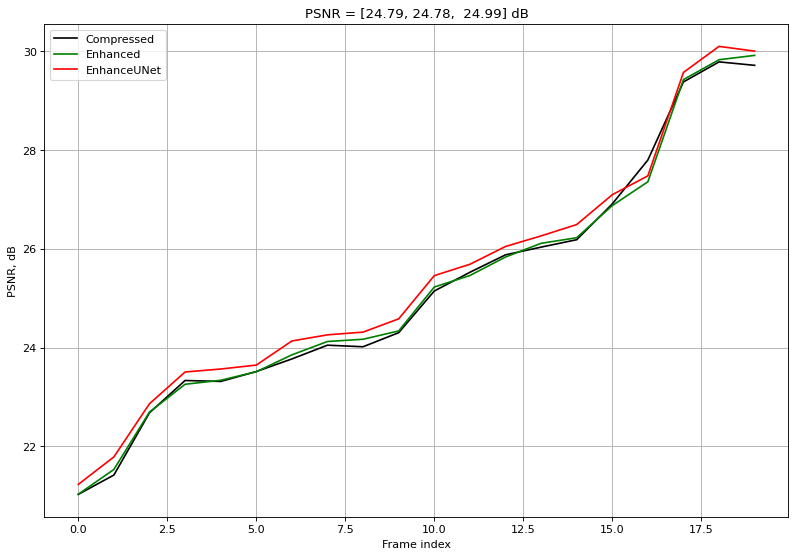

In [20]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)

ind = np.argsort(PSNRENCH)

plt.plot(PSNRCOMP[ind], label='Compressed', color='black')
plt.plot(PSNRENCH[ind], label='Enhanced', color='green')
plt.plot(PSNRUNET[ind], label='EnhanceUNet', color='red')
plt.xlabel('Frame index')
plt.ylabel('PSNR, dB')
plt.grid()
plt.legend()
tit = "PSNR = [%.2f, %.2f,  %.2f] dB" % (np.mean(PSNRCOMP[:ind[-1]]), np.mean(PSNRENCH[:ind[-1]]), np.mean(PSNRUNET[:ind[-1]]))
plt.title(tit)
plt.show()